# Text classification with Transformers

In this exercise we will create a deep neural network model for text classification, using the Transformer architecture as presented in today's lecture. 

We will use `PyTorch` python library which is an open-source machine learning framework. `PyTorch` is used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab. 

Along with `PyTorch` basic features, we will use `torchtext`, a python package that consists of data processing utilities and popular datasets for natural language.

Since we are using state-of-the-art libraries and already implemented preprocessing pipelines, the main purpose of this exercise is not to implement the low level internals of a neural network, but to get familiar with the PyTorch terminology and ecosystem by utilizing its API. Extended reference to the API can be found here: https://pytorch.org/.

In [1]:
import torch
from torchtext.data import get_tokenizer
from torch.utils.data import Dataset, DataLoader
from torchtext.datasets import IMDB
from collections import Counter, OrderedDict
from torchtext.vocab import vocab, GloVe
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support

## Part 1: Data proprocessing

The dataset that will be used to train the model contains IMDB movie reviews, labeled as positive or negative. Further documentation can be found here: http://ai.stanford.edu/~amaas/data/sentiment/

In order to create the preprocessing pipeline, we will extend the `torch.utils.data.Dataset` class which allows us to use pre-loaded datasets as well as our own data. In this way, we will be able to decouple preprocessing from modeling and transform the dataset into a compatible input for the PyTorch pipeline. 

More details can be found here: 
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

In [2]:
class TextClassificationDataset(Dataset):

    def __init__(self, tokenizer, text_vocab, label_vocab, split='train'):
        print(f'Numericalising tokens for {split} set...', end="", flush=True)
        data = IMDB(split=split)
        self.dset = []
        self.labels = []
        self.text_vocab = text_vocab
        self.label_vocab = label_vocab
        for label, line in data:
            tokens = tokenizer(line.rstrip())
            self.dset.append([self.text_vocab[w] for w in tokens])
            self.labels.append(self.label_vocab[str(label)])
        print('done')
        print(f'Number of {split} samples: {len(self.dset)}')

    def __len__(self):
        return len(self.dset)

    def __getitem__(self, idx):
        tokens = self.dset[idx]
        label = self.labels[idx]
        return tokens, label

    def tokens(self):
        return self.text_vocab.get_itos()

    def vocab_size(self):
        return len(self.text_vocab)

    def num_classes(self):
        return len(self.label_vocab)

    @classmethod
    def build_vocab(cls, tokenizer, split='train', min_freq=1, pad_token='<pad>', unk_token='<unk>'):
        print(f'Building vocab for IMDB...', end="", flush=True)
        data = IMDB(split=split)
        tokens = []
        labels = []
        for label, line in data:
            tokens += tokenizer(line.rstrip())
            labels.append(str(label))

        def create_vocab(counts, mf=1):
            counter = Counter(counts)
            sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
            ordered_dict = OrderedDict(sorted_by_freq_tuples)
            return vocab(ordered_dict, min_freq=mf)

        text_vocab = create_vocab(tokens, min_freq)
        # set index for padding token
        text_vocab.insert_token(pad_token, 0)
        # set default index for unknown token
        text_vocab.append_token(unk_token)
        text_vocab.set_default_index(text_vocab[unk_token])
        label_vocab =  create_vocab(labels)
        print('Done!')
        print(f'Number of tokens: {len(text_vocab)}')
        print(f'Classes: {label_vocab.get_stoi()}')
        return cls(tokenizer, text_vocab, label_vocab, split)

#### Run preprocessing

In [3]:
# initialize pipeline
seed = 100
torch.manual_seed(seed)
tokenizer = get_tokenizer("basic_english")

Call the `build_vocab()` static function to get the training set.

In [4]:
# preprocess input
# ------ YOUR CODE HERE ------
train_set = TextClassificationDataset.build_vocab(tokenizer, split='train', min_freq=2)
# ------ YOUR CODE HERE ------

Building vocab for IMDB...Done!
Number of tokens: 51718
Classes: {'pos': 1, 'neg': 0}
Numericalising tokens for train set...done
Number of train samples: 25000


## Part 2: Attention model

As presented in the lecture, attention models, or attention architecture, are input processing techniques for neural networks that allow the network to focus on specific aspects of a complex input and therefore capture contextual dependencies among words in a text.

Transformers use this attention mechanism as a building block, differentially weighting the significance of each part of the input data.

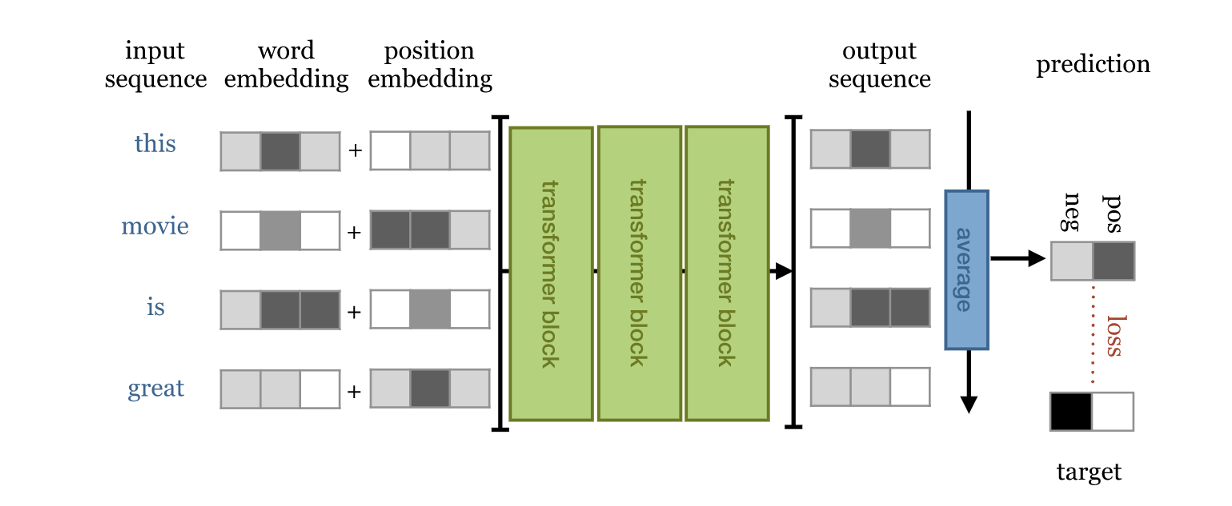

In this exercise, we will build a Transformer based neural network, utilizing the `TransformerEncoderLayer` of `PyTorch`: https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html

#### Embeddings

In this pipeline, we will use as word embeddings the `GloVe` pre-trained representations. This will serve as the input in our model along with the positional embeddings as presented in the diagram above.

In [5]:
# load pretrained embeddings
vec = GloVe(name='6B', dim=50)
embeddings = vec.get_vecs_by_tokens(train_set.tokens(), lower_case_backup=True)

.vector_cache/glove.6B.zip:  63%|██████▎   | 546M/862M [02:52<01:39, 3.17MB/s]    


KeyboardInterrupt: 

In [ ]:
class AttentionModel(nn.Module):
    def __init__(
            self,
            vocab_size,
            num_label,
            e_dim=100,
            num_layer=1,
            num_head=2,
            dropout=0.1,
            max_len=512,
            padding_idx=0,
            weights=None,
            freeze=True,
            device=torch.device('cpu')):

        super().__init__()
        self.padding_idx = padding_idx
        self.max_len = max_len
        if weights is None:
            self.word_embeddings = nn.Embedding(vocab_size, e_dim, padding_idx=padding_idx)
            if freeze:
                self.word_embeddings.weight.requires_grad = False
        else:
            self.word_embeddings = nn.Embedding.from_pretrained(weights, freeze=freeze, padding_idx=padding_idx)
        self.position_embeddings = nn.Embedding(max_len, e_dim)
        self.position_ids = torch.arange(max_len).to(device)
        self.LayerNorm = nn.LayerNorm(e_dim, eps=1e-5)
        self.dropout = nn.Dropout(dropout)

        transformer_layer = nn.TransformerEncoderLayer(d_model=e_dim, nhead=num_head, dim_feedforward=e_dim * 4)
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=num_layer)
        self.classifier = nn.Linear(e_dim, num_label)
        self.device = device
        self.to(device)

    def forward(self, inputs):
        token_ids, attn_masks = inputs
        batch_size = token_ids.size(0)
        batch_max_length = token_ids.size(1)
        # compute embeddings
        token_embs = self.word_embeddings(token_ids)
        pos_embs = self.position_embeddings(self.position_ids[:batch_max_length])
        embeddings = token_embs + pos_embs
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        # compute contextualised embeddings with transformer
        contextualised_embs = self.transformer(embeddings.permute(1, 0, 2), src_key_padding_mask=attn_masks)
        outputs = contextualised_embs.mean(0)
        logits = self.classifier(outputs)
        return logits

    def knn(self, token_ids, k=10):
        query = self.word_embeddings.weight[token_ids]
        x_src = F.normalize(query)
        x_tgt = F.normalize(self.word_embeddings.weight)
        # compute cosine similarity
        scores = x_src @ x_tgt.t()
        top_values, top_indices = torch.topk(scores, k + 1)
        return top_indices[:, 1:]  # remove top1 since it is the target token

    def collate_batch(self, batch):
        label_list, text_list, lengths = [], [], []
        for (_text, _label) in batch:
            label_list.append(_label)
            text_list.append(_text)
            lengths.append(len(_text))
        max_length = min(max(lengths), self.max_len)
        # truncate or add padding to the right hand side
        for i, _text in enumerate(text_list):
            if len(_text) < max_length:  # pad
                text_list[i] += [self.padding_idx] * (max_length - len(_text))
            else:  # truncate
                text_list[i] = _text[:max_length]
        label_list = torch.tensor(label_list, dtype=torch.long).to(self.device)
        text_list = torch.tensor(text_list, dtype=torch.long).to(self.device)
        attn_mask = text_list == self.padding_idx
        return label_list, (text_list, attn_mask)

In [ ]:
# create model by calling the AttentionModel class
# ------ YOUR CODE HERE ------
model = AttentionModel(
    vocab_size=train_set.vocab_size(), 
    num_label=train_set.num_classes(), 
    e_dim=50,
    max_len=512,
    num_head=2,
    num_layer=1,
    weights=embeddings,
    freeze='store_true',
    padding_idx=train_set.text_vocab['<pad>'],
    device=torch.device('cpu'))
# ------ YOUR CODE HERE ------

#### Evaluate embeddings before training 

We will evaluate how the model performs by finding k-nearest neighbors on a set of words. Since no training has been made yet, note that the knowledge of the model comes only from the pre-trained embeddings.

In [ ]:
@torch.no_grad()
def word_knn(model, valid_set, vocab, top=10):
    print('--------------------------------------------------------------------------------')
    print('Validation - top 10 nearest neighbors ------------------------------------------')
    valid_token_ids = vocab.lookup_indices(valid_set)
    top_indices = model.knn(valid_token_ids, top)

    for i, word in enumerate(valid_set):
        results = ' '.join([vocab.lookup_token(top_indices[i, k].item()) for k in range(top)])
        print(f'{word}: {results}')
    print('--------------------------------------------------------------------------------')

In [ ]:
# print out nearest neighbors before training
words = ['excellent', 'bad', 'terrible', 'awesome']

# ------ YOUR CODE HERE ------
word_knn(model, words, train_set.text_vocab)
# ------ YOUR CODE HERE ------

## Part 3: Training

For the training part we need to define a loss function ([CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)) and an optimizer ([Adam](https://pytorch.org/docs/stable/optim.html)).

To efficiently manipulate the data during training, we will use the build-in 
[Data Loader](https://pytorch.org/docs/stable/data.html) class of `PyTorch`.

**Please refer to the documentation of each component in order to call properly the API.**

In [ ]:
# ------ YOUR CODE HERE ------
# define the loss function
ce_loss = nn.CrossEntropyLoss()

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# define training dataloader
train_dataloader = DataLoader(train_set, 
                              batch_size=128, 
                              shuffle=True, 
                              collate_fn=model.collate_batch)
# ------ YOUR CODE HERE ------

In [ ]:
# loop over training epochs
EPOCHS = 1  # change number of epochs and see differences in performance
for epoch in range(1, EPOCHS + 1):
    pbar = tqdm(train_dataloader)
    pbar.set_description("[Epoch {}]".format(epoch))
    for labels, inputs in pbar: 
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = ce_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        # display the loss 
        pbar.set_postfix(loss=loss.item())

## Part 4: Testing

After training, we will use the remaining test set for evaluating our performance in the text classification task on the IMDB dataset. 

In [ ]:
# ------ YOUR CODE HERE ------
# create test set
test_set = TextClassificationDataset(
    tokenizer, 
    text_vocab=train_set.text_vocab, 
    label_vocab=train_set.label_vocab,
    split='test')

test_dataloader = DataLoader(test_set, 
                             batch_size=128*2, 
                             shuffle=False, 
                             collate_fn=model.collate_batch)
# ------ YOUR CODE HERE ------

In [ ]:
y_true = []
y_pred = []
with torch.no_grad():
    model.eval()
    for labels, inputs in tqdm(test_dataloader, desc='[Testing]'):
        logits = model(inputs)
        y_pred += logits.argmax(dim=1).tolist()
        y_true += labels.tolist()

In [ ]:
pre, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

print('------- Evaluation metrics --------')
print(f'Precision: {pre*100:.2f}%')
print(f'Recall: {rec*100:.2f}%')
print(f'F1 score: {f1*100:.2f}%')
print('-' * 35)

#### Evaluate embeddings after training

We will evaluate how the model performs by finding k-nearest neighbors on a set of words after training. You will notice that the more epochs the model has run, the more semantically closed the neighbors will be.

In [ ]:
# print out nearest neighbors after training
word_knn(model, ['excellent', 'bad', 'terrible', 'awesome'], train_set.text_vocab)